In [ ]:
import numpy as np
import matplotlib.pyplot as plt

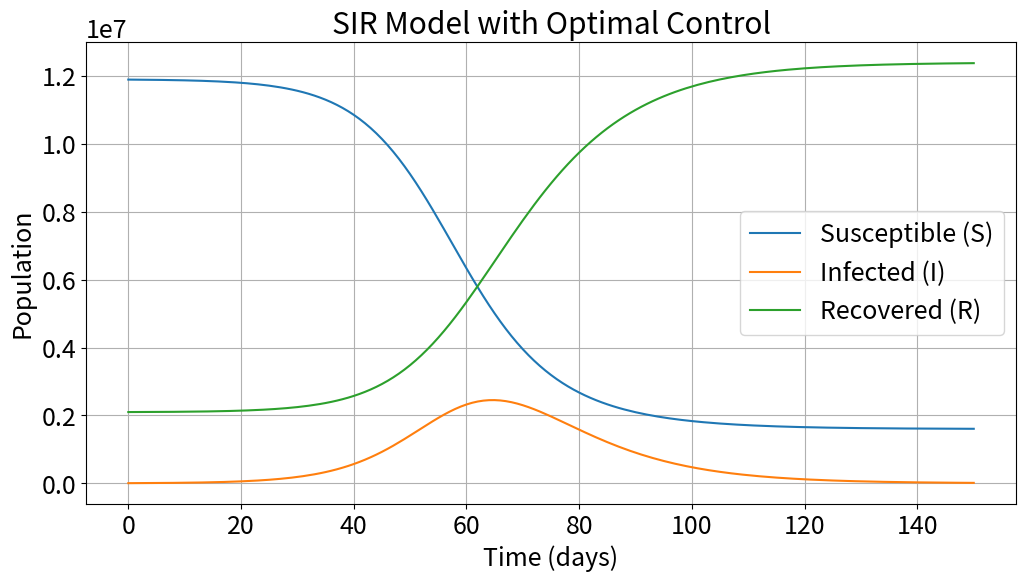

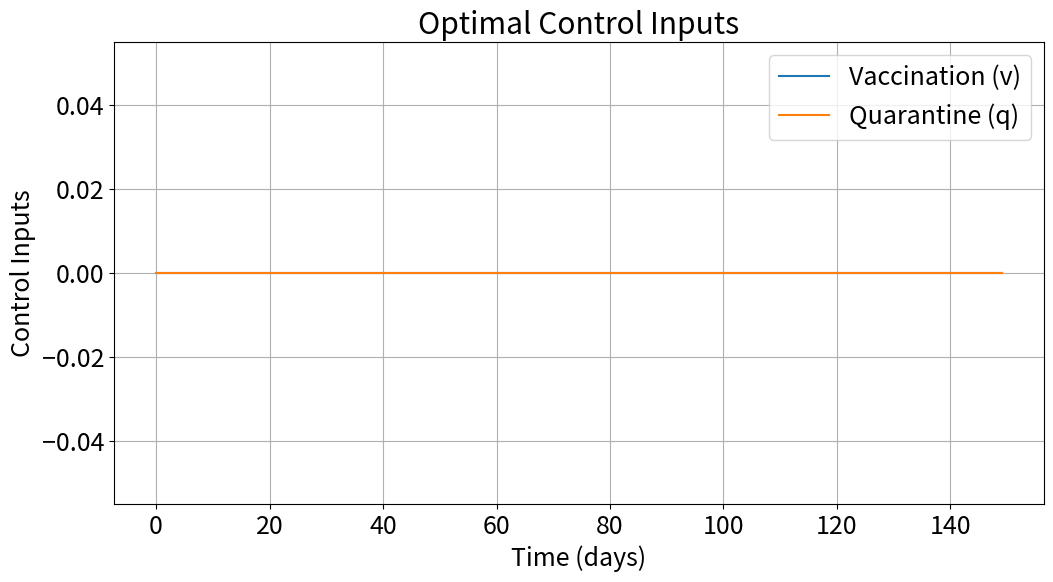

In [8]:


# パラメータ設定
T = 150  # 時間ステップ
dt = 1  # 時間刻み
N = 1.4 * 10**7    # 全人口

I0 = 5288            # 初期感染者数
R0= N * 0.15             # 初期回復者数
S0 = N - I0 - R0   # 初期の感受性者数
gamma = 0.1        # 回復率
r0 = 2.28        # 基本再生産数
beta = r0 * gamma / S0  # 伝染率

V_max = 20  # ワクチン最大接種量
Q_max = 20  # 隔離最大量

# 重みパラメータ
mu_I = 1  # 感染者数のコスト
mu_v = 1  # ワクチンコスト
mu_q = 1  # 隔離コスト



# 初期化
S = np.zeros(T + 1)
I = np.zeros(T + 1)
R = np.zeros(T + 1)
v = np.zeros(T)
q = np.zeros(T)

lambda_S = np.zeros(T + 1)
lambda_I = np.zeros(T + 1)
lambda_R = np.zeros(T + 1)

# 初期状態と終端条件
S[0], I[0], R[0] = S0, I0, R0
lambda_S[-1], lambda_I[-1], lambda_R[-1] = 0, 2 * mu_I * I[-1], 0

# 反復計算
epsilon = 1e-3  # 収束条件
max_iter = 100  # 最大反復回数
for iteration in range(max_iter):
    # 逆向きに共役変数を更新
    for t in reversed(range(T)):
        lambda_S[t] = lambda_S[t + 1] + beta * I[t] * (lambda_I[t + 1] - lambda_S[t + 1])
        lambda_I[t] = lambda_I[t + 1] + 2 * mu_I * I[t] + beta * S[t] * (lambda_I[t + 1] - lambda_S[t + 1]) - gamma * (lambda_R[t + 1] + lambda_I[t + 1])
        lambda_R[t] = lambda_R[t + 1]

    # 順方向に状態を更新
    prev_v = v.copy()
    prev_q = q.copy()
    for t in range(T):
        # 最適制御入力の計算
        v[t] = np.clip((lambda_S[t + 1] - lambda_R[t + 1]) / (2 * mu_v), 0, V_max)
        q[t] = np.clip((lambda_I[t + 1] - lambda_R[t + 1]) / (2 * mu_q), 0, Q_max)

        # 状態遷移
        S[t + 1] = max(0, S[t] - beta * S[t] * I[t] - v[t])
        I[t + 1] = max(0, I[t] + beta * S[t] * I[t] - gamma * I[t] - q[t])
        R[t + 1] = max(0, R[t] + gamma * I[t] + v[t] + q[t])

    # 収束判定
    if np.max(np.abs(v - prev_v)) < epsilon and np.max(np.abs(q - prev_q)) < epsilon:
        break

# 結果のプロット
time = np.arange(T + 1)

plt.figure(figsize=(12, 6))
plt.plot(time, S, label='Susceptible (S)')
plt.plot(time, I, label='Infected (I)')
plt.plot(time, R, label='Recovered (R)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIR Model with Optimal Control')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.arange(T), v, label='Vaccination (v)')
plt.plot(np.arange(T), q, label='Quarantine (q)')
plt.xlabel('Time (days)')
plt.ylabel('Control Inputs')
plt.title('Optimal Control Inputs')
plt.legend()
plt.grid(True)
plt.show()